In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np

import score_model as sc
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import seaborn as sns
import math as m
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline, NaturalCubicSpline)
from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)
from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)
plt.style.use('bmh')

# Predicting Sale Price of Heavy Equipment

<img src="https://i.ytimg.com/vi/ZjGIAe8zUj8/hqdefault.jpg">

## Workflow
### - New git repo, and creating feature branches for added materials

### - First cleaning data as a group so that we end up with the same data

### - Set to different tasks after prelim analysis and cleaning of data

### - Compile notes and presentation as we work forward


## EDA

### Cleaning Data
   ##### - High counts of missing data across the majority of the columns
   ##### - every row contains at least one null value so can't use dropna
   ##### - considered getting rid of auctioneers, but decided to keep as potential categorical variable (only 5% nulls)
   ##### - create 30% sample of the data in order to do EDA
   ##### - change tiresize from categorical to continuous data 

###### Read in CSV

In [21]:
df = pd.read_csv('predict_auction_price/data/Train.csv')


df["SalePrice"].astype(int)
y = df['SalePrice']

df.info()

/Users/tbot/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       4

### Some of our categorical features have a large number of unique values

In [22]:
def count_categories(df):
    subset = df.select_dtypes(include=['object'])
    cat_dict = {}
    for column in df.columns:
        cat_dict[column] = df.groupby(column).count().shape[0]
    return cat_dict

In [23]:
import operator
# sorted_x = sorted(count_categories().items(), key=operator.itemgetter(1))
counts = count_categories(df)

#### For example, ModelID has 5218 different types of value

### Create a smaller sample of the dataframe in order to continue EDA

In [24]:
# 30% sample size of the data
df_samp = df.sample(frac=0.3)

### Creating Boxplots
- checking diffs in mean saleprice per category per qualitative variable, from which we can intuit if that variable will be useful in predicting salesprice


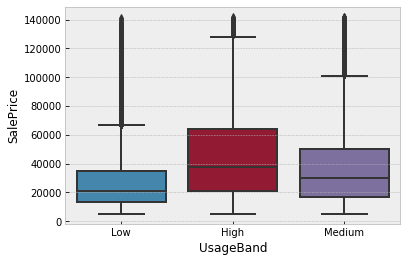

In [25]:
sns.boxplot(df['UsageBand'], df['SalePrice'])

In [26]:
count_values = list(counts.values()).sort()

low_cols = []
high_cols = []
med_cols = []
for key, value in counts.items():
    if value <= 8:
        low_cols.append(key)
    elif value > 8 and value <= 12:
        med_cols.append(key)
    elif value > 12 and  value <= 53:
        high_cols.append(key)

In [27]:
def plot_smalls():
    fig = plt.figure(figsize=[15,15])
    for x, i in enumerate(low_cols[:len(low_cols) // 2]):
        ax = fig.add_subplot(4,4,x + 1)
        ax = sns.boxplot(df[i], df['SalePrice'])
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=[15,15])
    for x, i in enumerate(low_cols[(len(low_cols) // 2) + 1:]):
        ax = fig.add_subplot(4,4,x + 1)
        ax = sns.boxplot(df[i], df['SalePrice'])
        plt.tight_layout()
    plt.show()

def plot_meds():
    fig = plt.figure(figsize=[15,15])
    for x, i in enumerate(med_cols):
        ax = fig.add_subplot(2,1,x + 1)
        ax = sns.boxplot(df[i], df['SalePrice'])
    plt.tight_layout()
    plt.show()

def plot_highs():
    for x, i in enumerate(high_cols):
        fig = plt.figure(figsize=[10,10])
        ax = fig.add_subplot(111)
        ax = sns.boxplot(df[i], df['SalePrice'])
        plt.xticks(rotation=75)
        plt.suptitle(f"{i} Against SalePrice")
        plt.show()

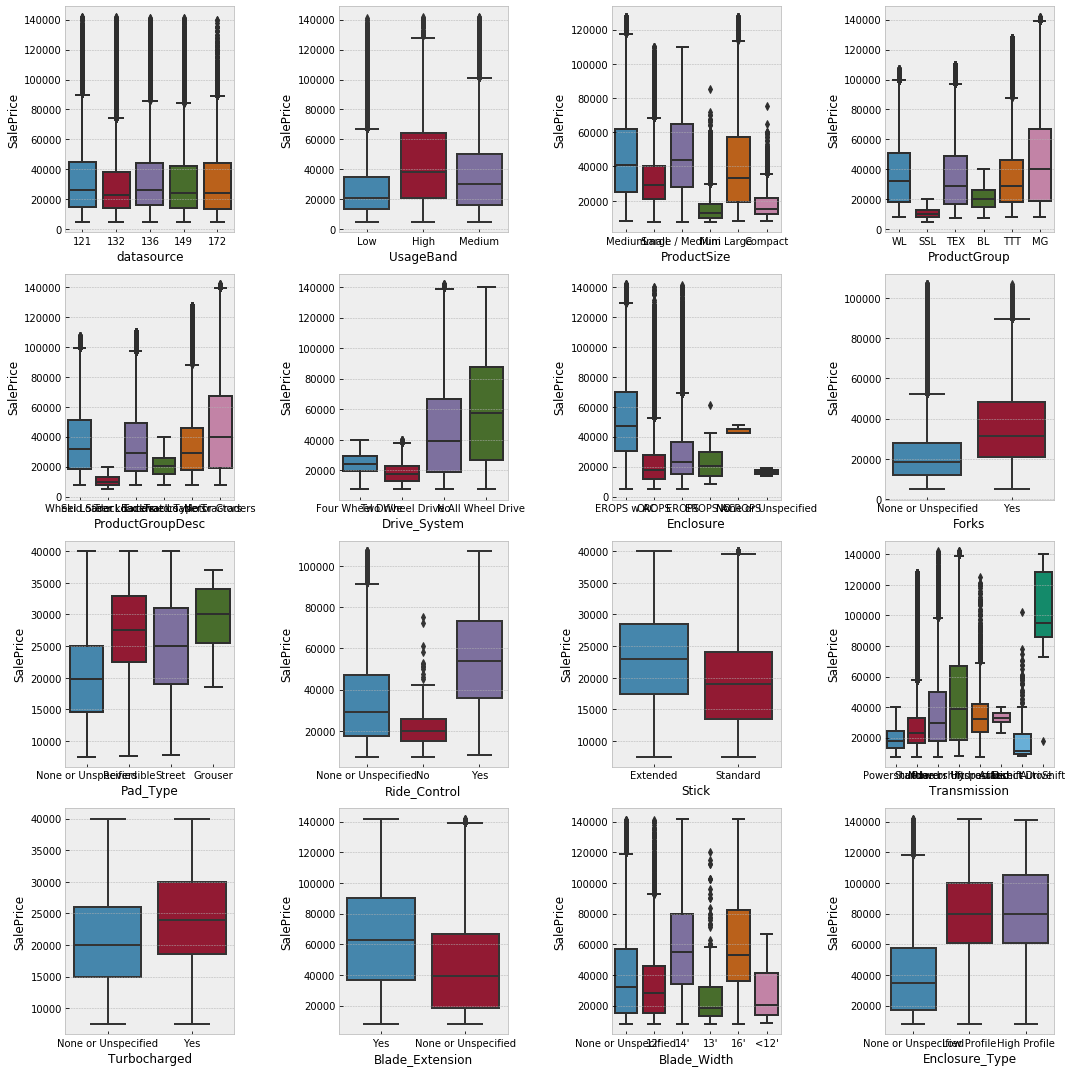

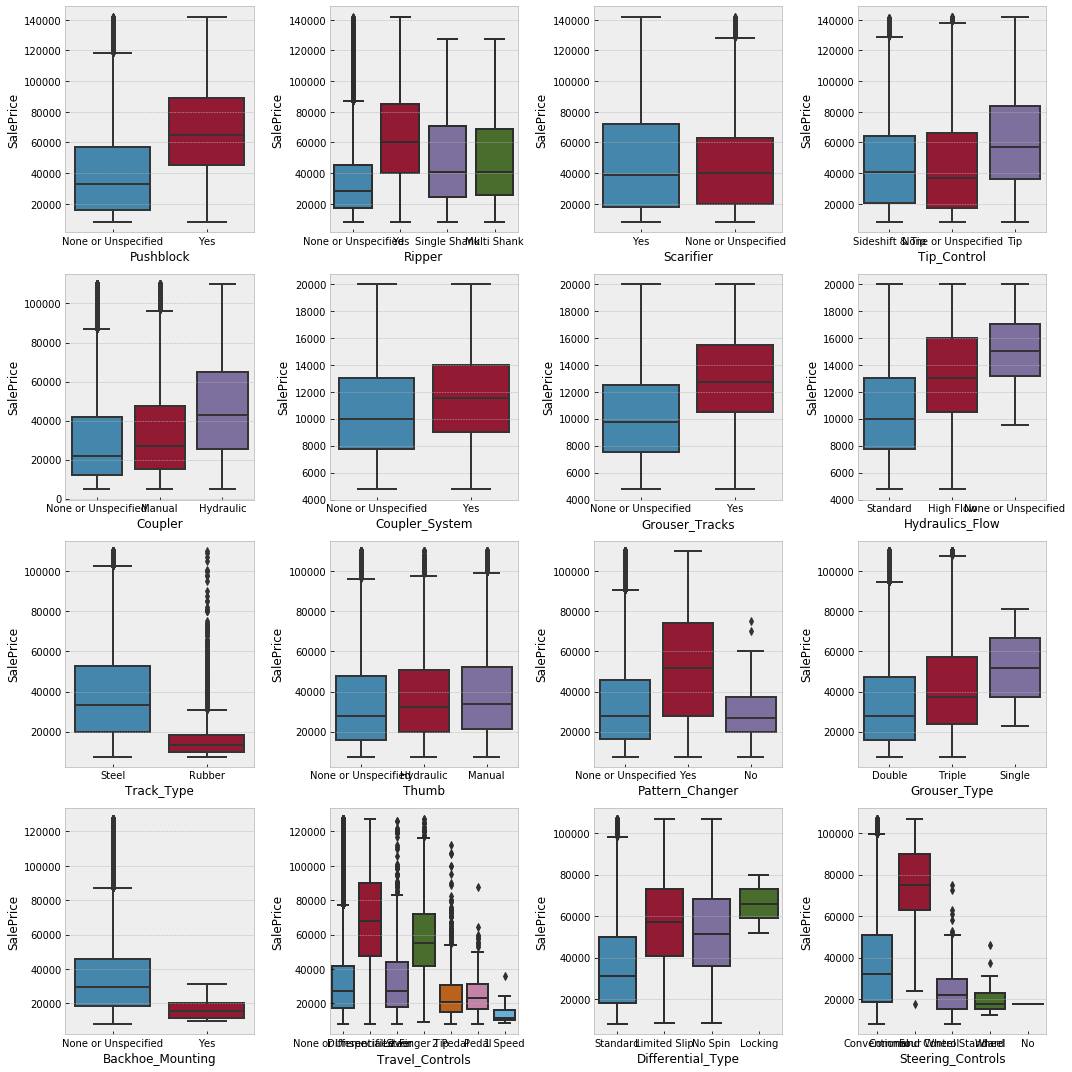

In [28]:
plot_smalls()

### Imputing Data with Random selection from non-NaN

In [29]:
import random

def replace_nans(data, column_name):
    items = data[column_name].dropna(axis=0, inplace = False)
    data[column_name].fillna(random.choice(list(items)), inplace = True)

In [30]:
# Count of NaNs in 'Product Size' before
df['ProductSize'].isnull().sum()

210775

In [31]:
replace_nans(df, 'ProductSize')

# Count of NaNs in 'Product Size' before
df['ProductSize'].isnull().sum()


0

### Other Cleaning of NaNs
##### - Changing categorical to ordinal

# Modeling

In [32]:



# counts = count_categories(df)
we_dont_want = {k for k,v in counts.items() if v > 29}
df.drop(we_dont_want, inplace=True, axis=1)
X = df
X = pd.get_dummies(X)

# X.drop(['MachineHoursCurrentMeter','auctioneerID'], inplace=True, axis = 1)



In [33]:
X.head()

,datasource,UsageBand_High,UsageBand_Low,UsageBand_Medium,ProductSize_Compact,ProductSize_Large,ProductSize_Large / Medium,ProductSize_Medium,ProductSize_Mini,ProductSize_Small,...,Travel_Controls_Pedal,Differential_Type_Limited Slip,Differential_Type_Locking,Differential_Type_No Spin,Differential_Type_Standard,Steering_Controls_Command Control,Steering_Controls_Conventional,Steering_Controls_Four Wheel Standard,Steering_Controls_No,Steering_Controls_Wheel
0,121,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,121,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
2,121,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,121,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,121,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
scaler = StandardScaler()
las = Lasso()
las.fit(X, y)
new_X = X.loc[:, las.coef_ > 0]

/Users/tbot/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [35]:
loss  = make_scorer(sc.rmsle, greater_is_better=False)
#How to manage many models
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledRidge', Pipeline([('Scaler', StandardScaler()),('EN', Ridge())])))

In [36]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=3, random_state=21)
    cv_results = cross_val_score(model, new_X, y, cv=kfold, scoring=loss)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



/Users/tbot/Dropbox/0_galvanize/case_study_heavy_equipment/score_model.py:4: RuntimeWarning: invalid value encountered in log
  log_diff = np.log(predictions+1) - np.log(actual+1)
/Users/tbot/Dropbox/0_galvanize/case_study_heavy_equipment/score_model.py:4: RuntimeWarning: invalid value encountered in log
  log_diff = np.log(predictions+1) - np.log(actual+1)
/Users/tbot/Dropbox/0_galvanize/case_study_heavy_equipment/score_model.py:4: RuntimeWarning: invalid value encountered in log
  log_diff = np.log(predictions+1) - np.log(actual+1)


ScaledLR: -0.505908 (0.008839)


/Users/tbot/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/tbot/Dropbox/0_galvanize/case_study_heavy_equipment/score_model.py:4: RuntimeWarning: invalid value encountered in log
  log_diff = np.log(predictions+1) - np.log(actual+1)
/Users/tbot/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/tbot/Dropbox/0_galvanize/case_study_heavy_equipment/score_model.py:4: RuntimeWarning: invalid value encountered in log
  log_diff = np.log(predictions+1) - np.log(actual+1)
/Users/tbot/anaconda3/lib/python3.6/site-packages/sklearn/linear_mod

ScaledLASSO: -0.505872 (0.008820)


/Users/tbot/Dropbox/0_galvanize/case_study_heavy_equipment/score_model.py:4: RuntimeWarning: invalid value encountered in log
  log_diff = np.log(predictions+1) - np.log(actual+1)
/Users/tbot/Dropbox/0_galvanize/case_study_heavy_equipment/score_model.py:4: RuntimeWarning: invalid value encountered in log
  log_diff = np.log(predictions+1) - np.log(actual+1)


ScaledRidge: -0.505930 (0.008858)


/Users/tbot/Dropbox/0_galvanize/case_study_heavy_equipment/score_model.py:4: RuntimeWarning: invalid value encountered in log
  log_diff = np.log(predictions+1) - np.log(actual+1)


# What we didn't do
## - We didn't run on the test data
## - We used a standard alpha
## - Sorry we're late, we're terrible people
## - We didn't create plots after the EDA

# What we learned
## - Just get to the model
## - Don't pick this data set